In [2]:
from collections import Counter

In [3]:
import csv

In [4]:
import json

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
# datestr = "190805"
# datestr = "190704"
datestr = "190904"
datestr_prev = "190805"

In [8]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.size"] = 18

In [9]:
rank = pd.read_csv("data/" + datestr + "_rank.csv")

In [10]:
point = pd.read_json("data/" + datestr + "_ratedpointsum.json")
point = point.set_index("user_id")

In [11]:
ac = pd.read_json("data/" + datestr + "_ac.json")
ac = ac.set_index("user_id")

In [12]:
point_dic = point["point_sum"].to_dict()

In [13]:
ac_dic = ac["problem_count"].to_dict()

In [14]:
points = []
for i, user in enumerate(rank["user"]):
    if user in point_dic:
        points.append(point_dic[user])
    else:
        points.append(None)

In [15]:
rank["rated point sum"] = points

In [16]:
acs = []
for i, user in enumerate(rank["user"]):
    if user in ac_dic:
        acs.append(ac_dic[user])
    else:
        acs.append(None)

In [17]:
rank["ac"] = acs

In [18]:
rank.head()

,rank,country,user,affiliation,birth,rating,highest,match,win,rated point sum,ac
0,1,BY,tourist,ITMO University,1994.0,4023,4208,34,15,185200.0,211.0
1,2,RU,Petr,NaN,1985.0,3882,3882,32,2,145900.0,161.0
2,3,CN,apiad,unknown,1997.0,3850,3850,30,5,136500.0,154.0
3,4,RU,Um_nik,HSE,1996.0,3817,3919,35,4,191300.0,254.0
4,5,RU,LHiC,Moscow SU,NaN,3675,3812,38,2,363400.0,518.0


In [19]:
rank.to_csv(datestr + "_data.csv", columns=["user", "rated point sum", "rating"], header=True, index=False)

<Figure size 864x576 with 0 Axes>

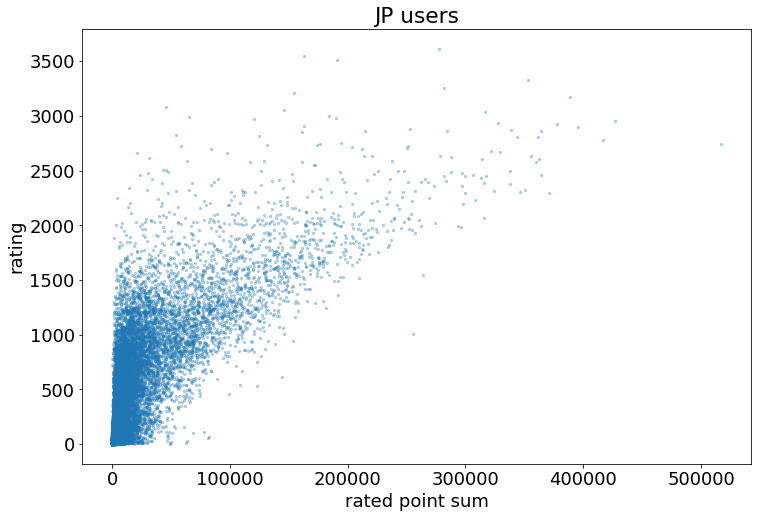

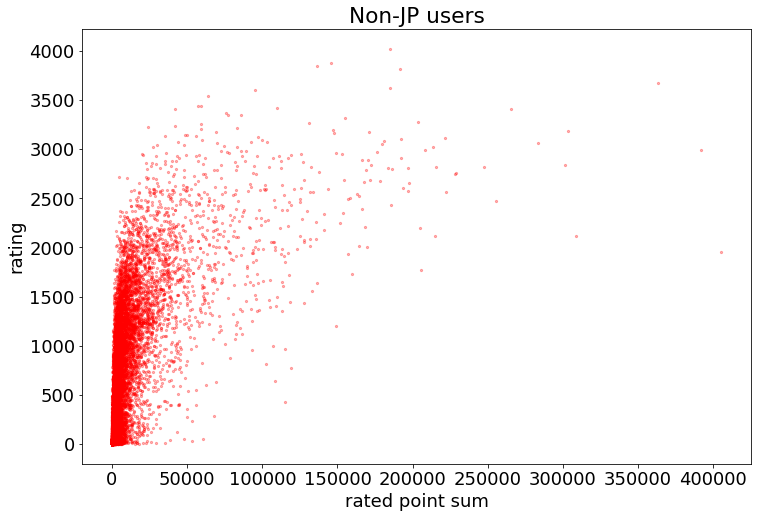

In [20]:
plt.tight_layout()
jp_user = rank[rank["country"] == "JP"]
jp_user.plot.scatter(x="rated point sum", y="rating", s=5, alpha=0.3)
plt.title("JP users")
plt.savefig("images/rated_point_sum_vs_rating.png")
nonjp_user = rank[rank["country"] != "JP"]
nonjp_user.plot.scatter(x="rated point sum", y="rating", s=5, c="r", alpha=0.3)
plt.title("Non-JP users")
plt.savefig("images/rated_point_sum_vs_rating.png")

In [20]:
# Calculate delta-rated point sum vs delta-rating

In [23]:
ranka = pd.read_csv(datestr_prev + "_data.csv")
ranka = ranka.set_index("user")

In [24]:
ranka.head()

,rated point sum,rating
user,,
tourist,180900.0,4049
Petr,139800.0,3862
Um_nik,182800.0,3768
apiad,130400.0,3758
w4yneb0t,121800.0,3710


In [25]:
a_rps_dic = ranka["rated point sum"].to_dict()
a_rate_dic = ranka["rating"].to_dict()

In [26]:
rankb = pd.read_csv(datestr + "_data.csv")
rankb["d-rps"] = None
rankb["d-rate"] = None

In [28]:
rankb["rating"].head()

0    4023
1    3882
2    3850
3    3817
4    3675
Name: rating, dtype: int64

In [29]:
import numpy as np

In [47]:
rpss = []
rates = []
for i, (user, n_rps, n_rate, d_rps, d_rate) in enumerate(rankb.values):
    if user in a_rps_dic:
        if user == "nagitaosu":
            print(n_rps - a_rps_dic[user])
        rankb.at[i, "d-rps"] = n_rps - a_rps_dic[user]
        rankb.at[i, "d-rate"] = n_rate - a_rate_dic[user]

15400.0


In [39]:
rankb_active = rankb[rankb["d-rps"] > 0].reset_index(drop=True)
rankb_active = rankb_active.set_index("user")
rankb_active.head()
print(len(rankb_active))

9870


In [32]:
sep_color = [[[], []] for _ in range(8)]
color_div = [400, 800, 1200, 1600, 2000, 2400, 2800, 5000]
for n_rps, n_rate, d_rps, d_rate in rankb_active.values:
    for i in range(8):
        if n_rate < color_div[i]:
            sep_color[i][0].append(d_rps)
            sep_color[i][1].append(n_rate)
            break

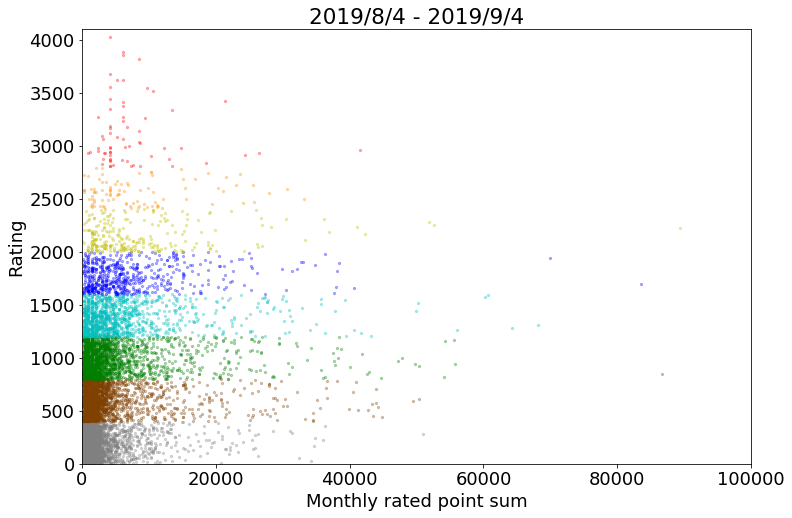

In [51]:
color_list = ["#808080", "#804000", "#008000", "#00C0C0", "#0000FF", "#C0C000", "#FF9000", "#FF0000"]
for i in range(8):
    plt.scatter(sep_color[i][0], sep_color[i][1], s=5, c=color_list[i], alpha=0.3)
plt.ylim(0, 4100)
plt.xlim(0, 100000)
plt.title("2019/8/4 - 2019/9/4")
plt.xlabel("Monthly rated point sum")
plt.ylabel("Rating")
plt.savefig("rate_vs_mrps_close.png")

In [52]:
rates = []
d_rpss = []
for n_rps, n_rate, d_rps, d_rate in rankb_active.values:
    if n_rate < 4200:
        rates.append(n_rate)
        d_rpss.append(int(d_rps))

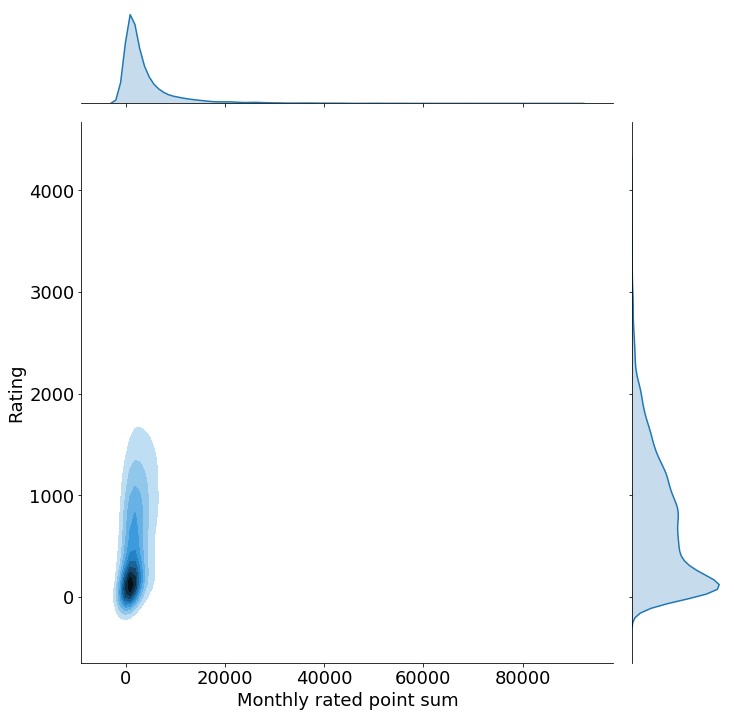

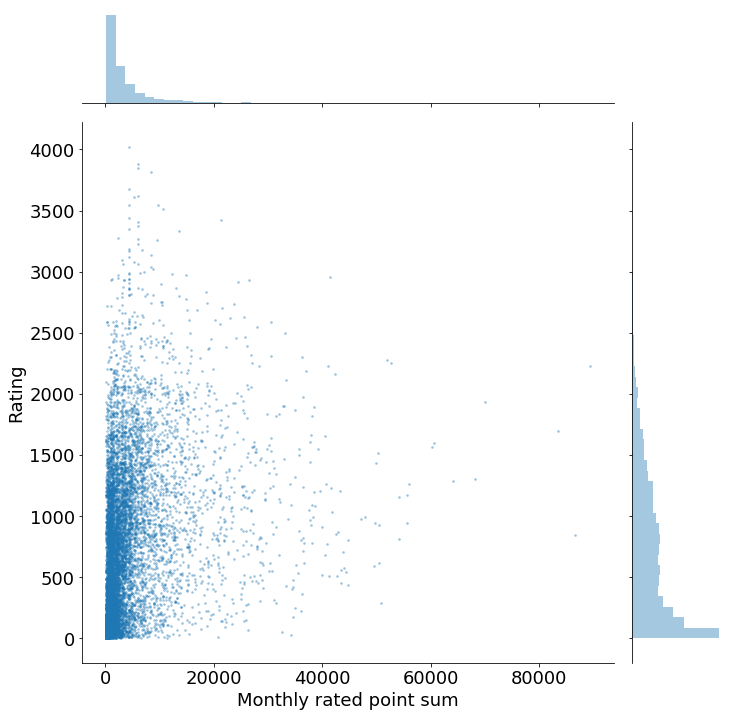

In [53]:
import seaborn as sns
import numpy as np
fig = sns.jointplot(x=d_rpss, y=rates, kind="kde", height=10)
fig.ax_joint.collections[0].set_alpha(0)
fig.set_axis_labels("Monthly rated point sum", "Rating")
fig.savefig("distplot2_close.png")
plt.show()
fig = sns.jointplot(x=d_rpss, y=rates, kind="scatter", height=10, alpha=0.3, s=3)
fig.set_axis_labels("Monthly rated point sum", "Rating")
fig.savefig("distplot_close.png")
plt.show()

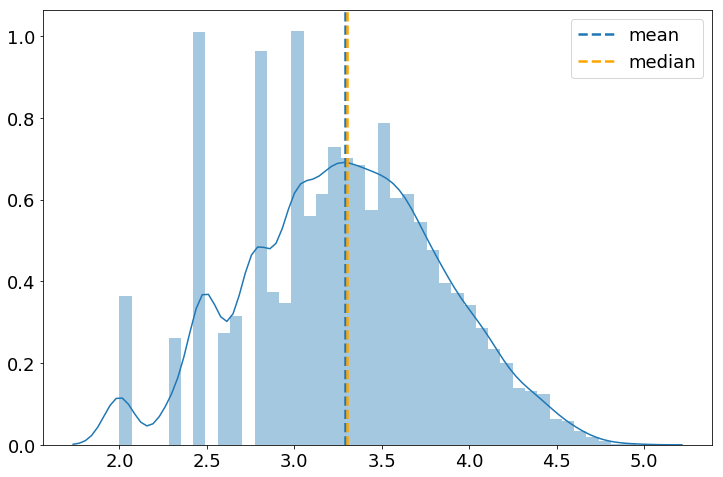

In [54]:
import seaborn as sns
import numpy as np
import math
import statistics
log_d_rpss = []
for item in d_rpss:
    log_d_rpss.append(math.log10(item))
m = statistics.mean(log_d_rpss)
median = statistics.median(log_d_rpss)
var = statistics.variance(log_d_rpss)
stdev = statistics.stdev(log_d_rpss)
fig = sns.distplot(log_d_rpss)
plt.axvline(x=m, linestyle='--', linewidth=2.5, label="mean")
plt.axvline(x=median, linestyle='--', linewidth=2.5, label="median", c="orange")
plt.legend()

No handles with labels found to put in legend.


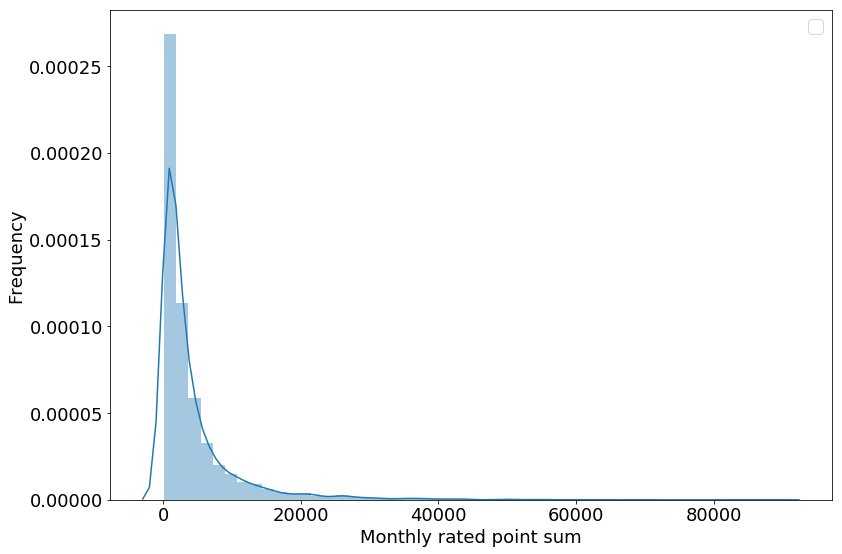

In [55]:
fig = sns.distplot(d_rpss)
plt.xlabel("Monthly rated point sum")
plt.ylabel("Frequency")
plt.tight_layout(True)
plt.legend()
plt.savefig("ijou21.png")

25002.55319543118
89796.0629078358


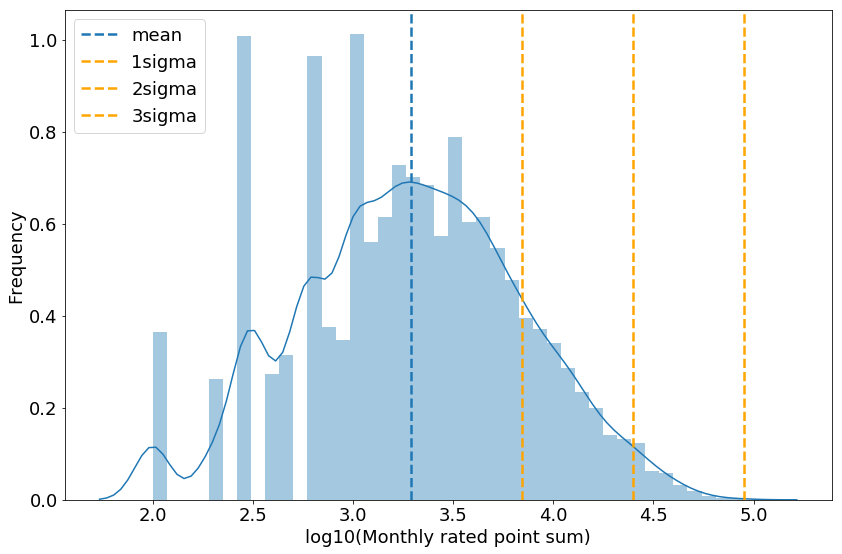

In [56]:
fig = sns.distplot(log_d_rpss)
plt.axvline(x=m, linestyle='--', linewidth=2.5, label="mean")
plt.axvline(x=m+stdev, linestyle='--', linewidth=2.5, label="1sigma", c="orange")
plt.axvline(x=m+stdev*2, linestyle='--', linewidth=2.5, label="2sigma", c="orange")
plt.axvline(x=m+stdev*3, linestyle='--', linewidth=2.5, label="3sigma", c="orange")
print(10**(m+stdev*2))
print(10**(m+stdev*3))
plt.xlabel("log10(Monthly rated point sum)")
plt.ylabel("Frequency")
plt.tight_layout(True)
plt.legend()
plt.savefig("ijou22.png")

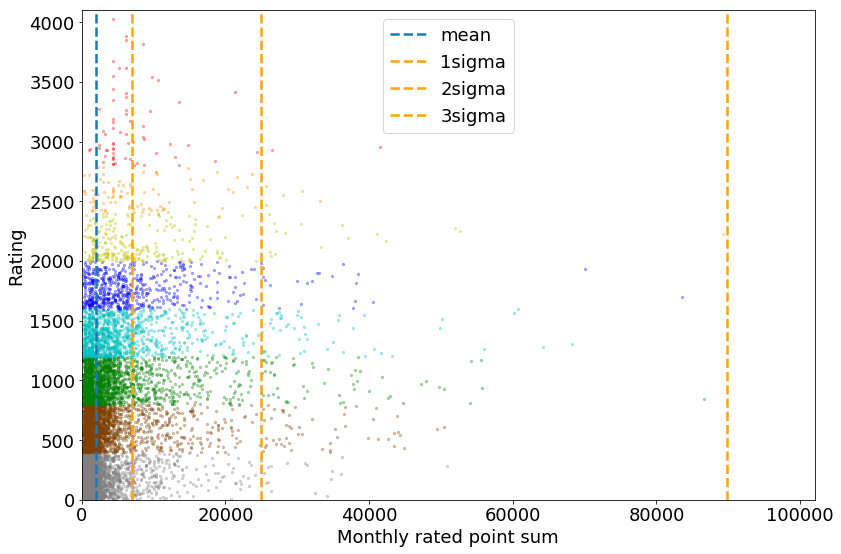

In [58]:
color_list = ["#808080", "#804000", "#008000", "#00C0C0", "#0000FF", "#C0C000", "#FF9000", "#FF0000"]
for i in range(8):
    plt.scatter(sep_color[i][0], sep_color[i][1], s=5, c=color_list[i], alpha=0.3)
plt.axvline(x=10**(m), linestyle='--', linewidth=2.5, label="mean")
plt.axvline(x=10**(m+stdev), linestyle='--', linewidth=2.5, label="1sigma", c="orange")
plt.axvline(x=10**(m+stdev*2), linestyle='--', linewidth=2.5, label="2sigma", c="orange")
plt.axvline(x=10**(m+stdev*3), linestyle='--', linewidth=2.5, label="3sigma", c="orange")    
plt.ylim(0, 4100)
plt.xlim(0, 102000)
plt.xlabel("Monthly rated point sum")
plt.ylabel("Rating")
plt.legend()
plt.tight_layout(True)
plt.savefig("ijou23.png")

1900 3500 13800 41300


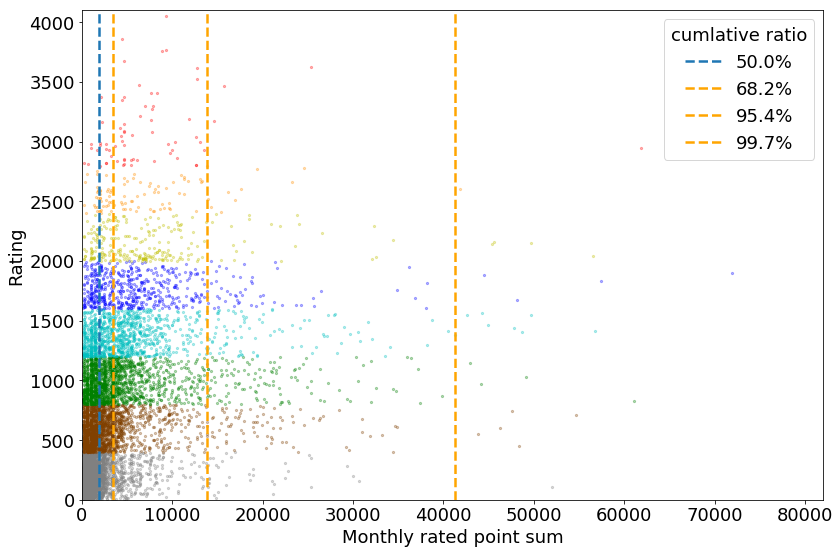

In [81]:
color_list = ["#808080", "#804000", "#008000", "#00C0C0", "#0000FF", "#C0C000", "#FF9000", "#FF0000"]
for i in range(8):
    plt.scatter(sep_color[i][0], sep_color[i][1], s=5, c=color_list[i], alpha=0.3)
d_rpss.sort()
half = d_rpss[len(d_rpss) // 2]
sig1 = d_rpss[int(len(d_rpss) * 0.682)]
sig2 = d_rpss[int(len(d_rpss) * 0.954)]
sig3 = d_rpss[int(len(d_rpss) * 0.997)]
plt.axvline(x=half, linestyle='--', linewidth=2.5, label="50.0%")
plt.axvline(x=sig1, linestyle='--', linewidth=2.5, label="68.2%", c="orange")
plt.axvline(x=sig2, linestyle='--', linewidth=2.5, label="95.4%", c="orange")
plt.axvline(x=sig3, linestyle='--', linewidth=2.5, label="99.7%", c="orange")
plt.ylim(0, 4100)
plt.xlim(0, 82000)
plt.xlabel("Monthly rated point sum")
plt.ylabel("Rating")
plt.legend(title = "cumlative ratio")
print(half, sig1, sig2, sig3)
plt.tight_layout(True)
plt.savefig("ijou1.png")